# Data: precip, modis, 0.01degree,0.1degree, 201501-202411

应该说是分别使用0.05，0.1，0.15的ndvi和precipitation数据拟合exp regression，选取模型中R2最大low resolution模型的参数用于0.01degree的ndvi，得到0.01degree下的precipitation估计，然后计算R2最大的模型的残差，通过插值将残差插值到0.01degree，然后和0.01degree下的precipitation估计相加后得到最终结果

In [60]:
import xarray as xr
precip001 = xr.open_dataset("D:/Desktop/mentor_research/data_imerg/nyc_precipitation_data_2015_to_present.nc")
precip001
# 假设变量名是 'precipitation'
precip001["precipitation"] = precip001["precipitation"].where(precip001["precipitation"] >= 0)


In [61]:
precip01 = precip001.coarsen(lat=10, lon=10, boundary="trim").mean()
precip01

<xarray.Dataset>
Dimensions:        (time: 119, lat: 5, lon: 10)
Coordinates:
  * time           (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2024-11-01
  * lon            (lon) float32 -74.05 -73.95 -73.85 ... -73.35 -73.25 -73.15
  * lat            (lat) float32 40.45 40.55 40.65 40.75 40.85
Data variables:
    precipitation  (time, lat, lon) float32 0.03915 1.699 ... 0.3174 0.05378
Attributes:
    title:                NASA IMERG Precipitation Data for New York City (20...
    description:          Monthly precipitation data from IMERG
    history:              Created on 2025-04-15
    source:               NASA IMERG
    spatial_resolution:   1000m
    temporal_resolution:  Monthly average
    west_lon:             -74.1
    east_lon:             -73.1
    south_lat:            40.4
    north_lat:            40.9

In [62]:
import numpy as np
modis001 = xr.open_dataset("D:/Desktop/mentor_research/data_modis/nyc_modis_data_2015_2025.nc")
modis001 = modis001.sel(time=modis001.time < np.datetime64("2024-12-01"))
modis001

<xarray.Dataset>
Dimensions:              (time: 119, lat: 50, lon: 100)
Coordinates:
  * time                 (time) datetime64[ns] 2015-01-01 ... 2024-11-01
  * lon                  (lon) float32 -74.1 -74.09 -74.08 ... -73.11 -73.1
  * lat                  (lat) float32 40.4 40.41 40.42 ... 40.88 40.89 40.9
Data variables:
    surface_temperature  (time, lat, lon) float32 ...
    vegetation_index     (time, lat, lon) float32 ...
    evapotranspiration   (time, lat, lon) float32 ...
    snow_cover           (time, lat, lon) float32 ...
    burned_area          (time, lat, lon) float32 ...
Attributes:
    title:                NASA MODIS Data for New York City (2002-2003)
    description:          Monthly averages of Surface Temperature, Vegetation...
    history:              Created on 2025-04-15
    source:               NASA MODIS
    spatial_resolution:   1000m
    temporal_resolution:  Monthly average
    west_lon:             -74.1
    east_lon:             -73.1
    south_lat:            40.4
    north_lat:            40.9

In [63]:
modis01 = modis001.coarsen(lat=10, lon=10, boundary="trim").mean()
modis01

<xarray.Dataset>
Dimensions:              (time: 119, lat: 5, lon: 10)
Coordinates:
  * time                 (time) datetime64[ns] 2015-01-01 ... 2024-11-01
  * lon                  (lon) float32 -74.05 -73.95 -73.85 ... -73.25 -73.15
  * lat                  (lat) float32 40.45 40.55 40.65 40.75 40.85
Data variables:
    surface_temperature  (time, lat, lon) float32 68.22 69.97 76.38 ... 0.0 0.0
    vegetation_index     (time, lat, lon) float32 0.1973 0.1195 ... -0.3 -0.3
    evapotranspiration   (time, lat, lon) float32 525.6 1.017e+03 ... 3.277e+03
    snow_cover           (time, lat, lon) float32 nan nan nan ... nan nan nan
    burned_area          (time, lat, lon) float32 -0.23 -0.53 ... -2.0 -2.0
Attributes:
    title:                NASA MODIS Data for New York City (2002-2003)
    description:          Monthly averages of Surface Temperature, Vegetation...
    history:              Created on 2025-04-15
    source:               NASA MODIS
    spatial_resolution:   1000m
    temporal_resolution:  Monthly average
    west_lon:             -74.1
    east_lon:             -73.1
    south_lat:            40.4
    north_lat:            40.9

# 1 Exp Regression(bad performance)

## 1.1 Resample to 0.05, 0.1, 0.15, use grid averaging

modis0.01 -> [0.01, 0.05, 0.1, 0.15]

precip0.01 -> [0.01, 0.05, 0.1, 0.15]

In [23]:
def resample_to_resolution(ds, target_res_deg, lat_name='lat', lon_name='lon'):
    
    lat_res = np.diff(ds[lat_name].values).mean()
    lon_res = np.diff(ds[lon_name].values).mean()

    lat_factor = int(round(target_res_deg / lat_res))
    lon_factor = int(round(target_res_deg / lon_res))

    print(f"Resampling to {target_res_deg}° with factor (lat: {lat_factor}, lon: {lon_factor})")

    ds_coarse = ds.coarsen({lat_name: lat_factor, lon_name: lon_factor}, boundary="trim").mean()
    return ds_coarse


In [24]:
ndvi_resampled = {}

for res in [0.05, 0.1, 0.15]:
    ndvi_resampled[f"{res}"] = resample_to_resolution(modis001.vegetation_index, res)
# ndvi_resampled['0.01']


Resampling to 0.05° with factor (lat: 5, lon: 5)
Resampling to 0.1° with factor (lat: 10, lon: 10)
Resampling to 0.15° with factor (lat: 15, lon: 15)


In [25]:
precip_resampled = {}

for res in [0.05, 0.1, 0.15]:
    precip_resampled[f"{res}"] = resample_to_resolution(precip001, res)


Resampling to 0.05° with factor (lat: 5, lon: 5)
Resampling to 0.1° with factor (lat: 10, lon: 10)
Resampling to 0.15° with factor (lat: 15, lon: 15)


In [26]:
ndvi_yearly_mean = {}

for res, da in ndvi_resampled.items():
    if 'time' in da.dims:
        ndvi_yearly_mean[f"{res}"] = da.groupby('time.year').mean('time')
    else:
        print(f"Resolution {res} has no 'time' dimension. Skipping.")


In [27]:
precip_yearly_mean = {}

for res, da in precip_resampled.items():
    if 'time' in da.dims:
        precip_yearly_mean[f"{res}"] = da.groupby('time.year').mean('time')
    else:
        print(f"Resolution {res} has no 'time' dimension. Skipping.")

In [28]:
ndvi001_yearly = modis001.vegetation_index.groupby('time.year').mean('time')

## Apply exp regression monthly: $precip = a \times e^{b \times ndvi}$

split data into training and test dataset

In [29]:
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def exp_func(ndvi, a, b):
    return a * np.exp(b * ndvi)


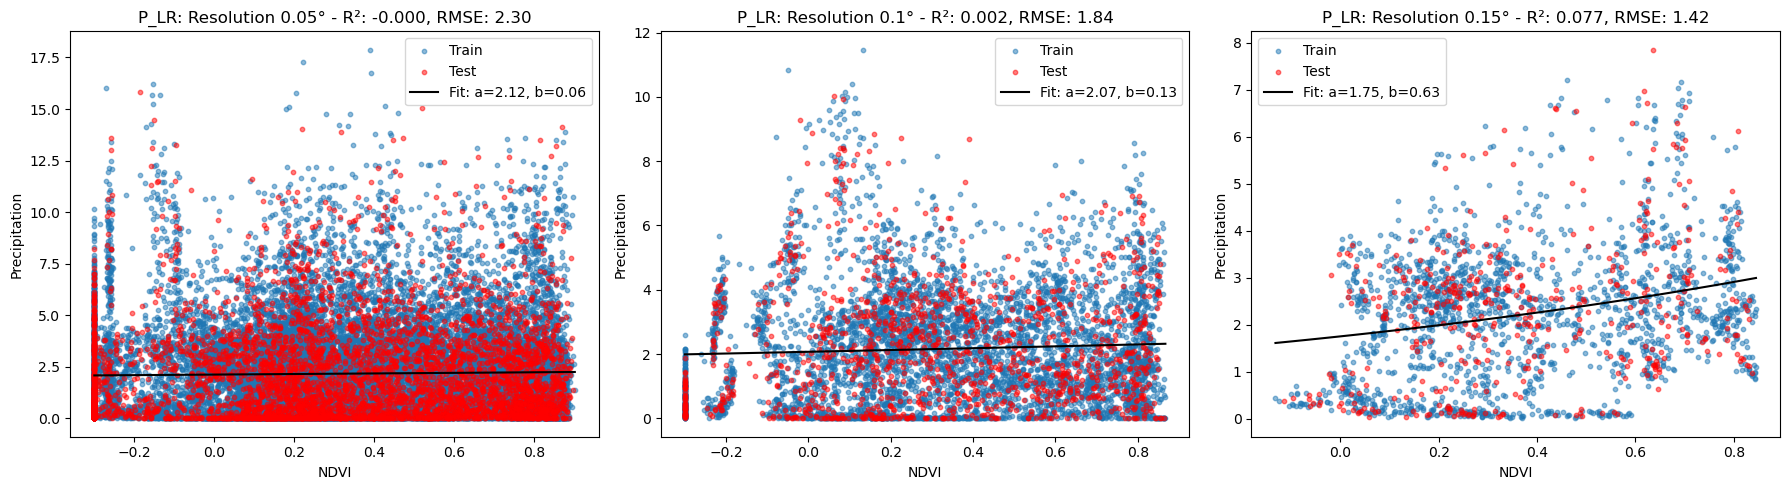

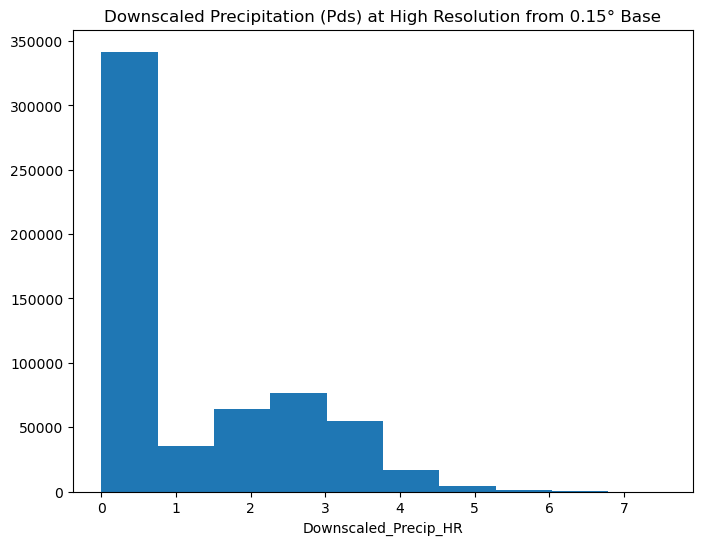

In [31]:
# Store training/test data and fitted curve for later plotting
fit_details = {}

# Updated fitting function: stores train/test data and prediction results
def fit_exp_split_save(ndvi_da, precip_da, test_size=0.2, seed=42):
    ndvi = ndvi_da.values.flatten()
    precip = precip_da.values.flatten()
    mask = (~np.isnan(ndvi)) & (~np.isnan(precip)) & (precip >= 0)
    ndvi = ndvi[mask]
    precip = precip[mask]

    x_train, x_test, y_train, y_test = train_test_split(ndvi, precip, test_size=test_size, random_state=seed)
    popt, _ = curve_fit(exp_func, x_train, y_train, maxfev=10000)
    a, b = popt

    y_pred_test = exp_func(x_test, a, b)
    rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    r2 = r2_score(y_test, y_pred_test)

    # Store data for plotting
    return {
        "a": a, "b": b, "r2": r2, "rmse": rmse,
        "x_train": x_train, "y_train": y_train,
        "x_test": x_test, "y_test": y_test,
        "y_pred_test": y_pred_test
    }

# Perform regression and save fit details
for res in ndvi_resampled:
    ndvi = ndvi_resampled[res]
    precip = precip_resampled[res].precipitation
    fit_details[res] = fit_exp_split_save(ndvi, precip)

# Plot regression results for all resolutions
fig, axes = plt.subplots(ncols=len(fit_details), figsize=(6 * len(fit_details), 5))

if len(fit_details) == 1:
    axes = [axes]

for ax, (res, result) in zip(axes, fit_details.items()):
    x_train = result["x_train"]
    y_train = result["y_train"]
    x_test = result["x_test"]
    y_test = result["y_test"]
    y_pred_test = result["y_pred_test"]
    a, b = result["a"], result["b"]

    # Fitted curve
    x_line = np.linspace(min(x_train.min(), x_test.min()), max(x_train.max(), x_test.max()), 100)
    y_line = exp_func(x_line, a, b)

    ax.scatter(x_train, y_train, s=10, label="Train", alpha=0.5)
    ax.scatter(x_test, y_test, s=10, label="Test", alpha=0.5, color="red")
    ax.plot(x_line, y_line, label=f"Fit: a={a:.2f}, b={b:.2f}", color="black")
    ax.set_title(f"P_LR: Resolution {res}° - R²: {result['r2']:.3f}, RMSE: {result['rmse']:.2f}")
    ax.set_xlabel("NDVI")
    ax.set_ylabel("Precipitation")
    ax.legend()

plt.tight_layout()
plt.show()

# Select the best resolution (based on highest R²)
best_res = max(fit_details.items(), key=lambda x: x[1]['r2'])[0]
best_model = fit_details[best_res]
best_ndvi_lr = ndvi_resampled[best_res]
best_precip_lr = precip_resampled[best_res].precipitation
a_best, b_best = best_model['a'], best_model['b']

# Compute Pe_LR and Δ_LR
pe_lr = a_best * np.exp(b_best * best_ndvi_lr)
delta_lr = best_precip_lr - pe_lr

# Interpolate Δ_LR → Δ_HR
hr_ndvi = modis001.vegetation_index.mean(dim="time")
delta_hr = delta_lr.interp_like(hr_ndvi, method="linear")

# Generate Pe_HR
pe_hr = a_best * np.exp(b_best * hr_ndvi)

# Compute final high-resolution precipitation map Pds
pds = pe_hr + delta_hr
pds.name = "Downscaled_Precip_HR"
pds = pds.where(pds >= 0, 0)


# Visualize final result
plt.figure(figsize=(8, 6))
pds.plot()
plt.title(f"Downscaled Precipitation (Pds) at High Resolution from {best_res}° Base")
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = precip001.precipitation.values.flatten()
y_pred = pds.values.flatten()

# Remove NaNs
mask = (~np.isnan(y_true)) & (~np.isnan(y_pred)) & (y_pred >= 0)
y_true = y_true[mask]
y_pred = y_pred[mask]

rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")


ValueError: operands could not be broadcast together with shapes (595000,) (5000,) 

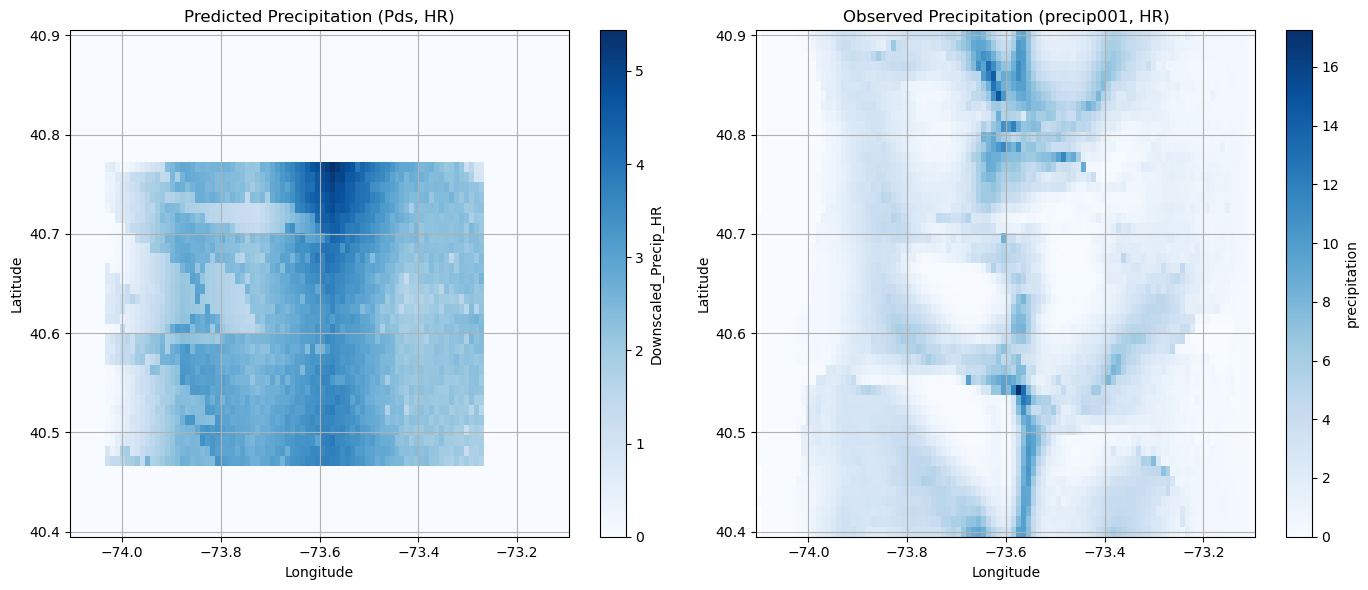

In [34]:
import matplotlib.pyplot as plt

# Step 1：对时间取平均
pds_mean = pds.mean(dim="time")
precip_mean = precip001["precipitation"].mean(dim="time")

# Step 2：创建并排图像
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 左图：预测值
pds_mean.plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Predicted Precipitation (Pds, HR)")

# 右图：真实值
precip_mean.plot(ax=axes[1], cmap="Blues")
axes[1].set_title("Observed Precipitation (precip001, HR)")

for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()


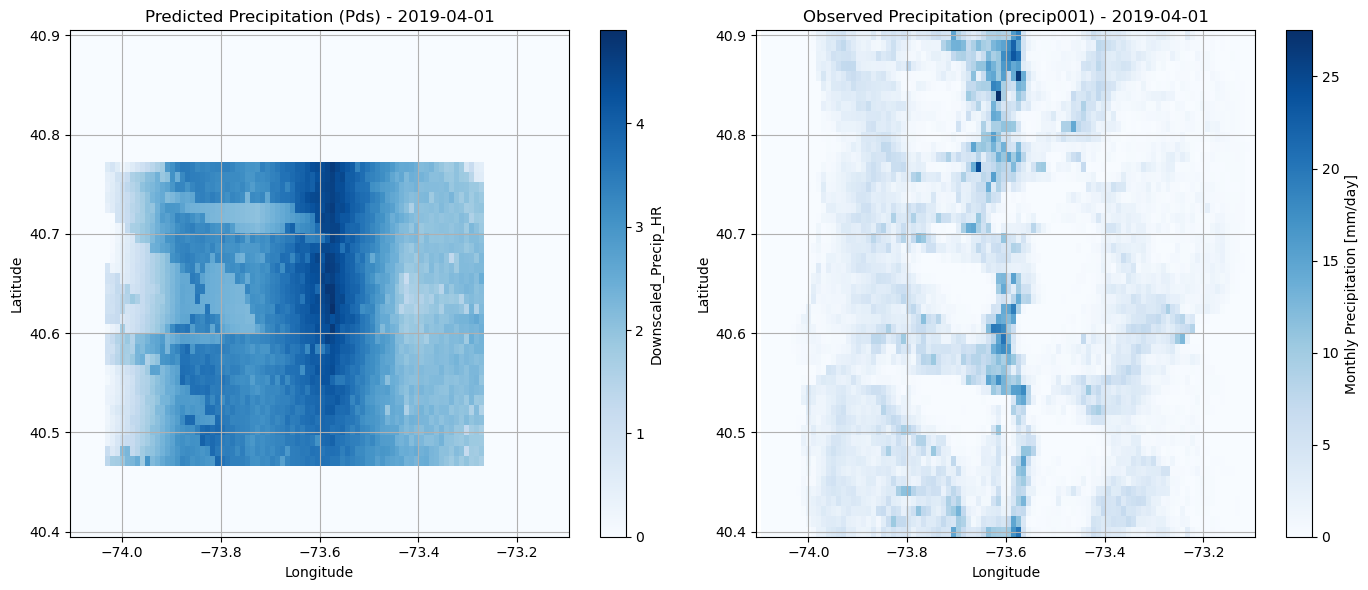

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1：选取一个随机时间索引
time_idx = np.random.randint(0, pds.sizes["time"])

# Step 2：提取该时间点对应的降水图
pds_single = pds.isel(time=time_idx)
precip_single = precip001["precipitation"].isel(time=time_idx)

# Step 3：创建并排图像
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pds_single.plot(ax=axes[0], cmap="Blues")
axes[0].set_title(f"Predicted Precipitation (Pds) - {str(pds.time.values[time_idx])[:10]}")

precip_single.plot(ax=axes[1], cmap="Blues")
axes[1].set_title(f"Observed Precipitation (precip001) - {str(precip001.time.values[time_idx])[:10]}")

for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()


## Apply exp regression yearly: $precip = a \times e^{b \times ndvi}$

应该说是分别使用0.05，0.1，0.15的ndvi和precipitation数据拟合exp regression，选取模型中R2最大low resolution模型的参数用于0.01degree的ndvi，得到0.01degree下的precipitation估计，然后计算R2最大的模型的残差，通过插值将残差插值到0.01degree，然后和0.01degree下的precipitation估计相加后得到最终结果

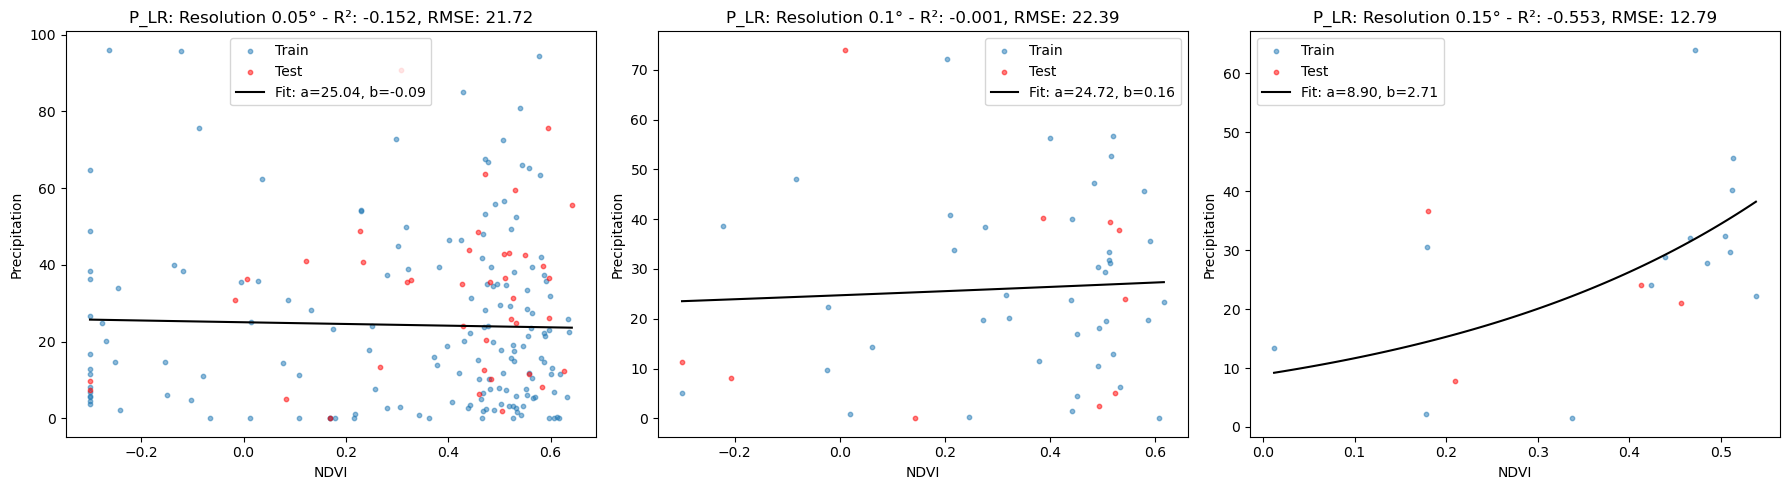

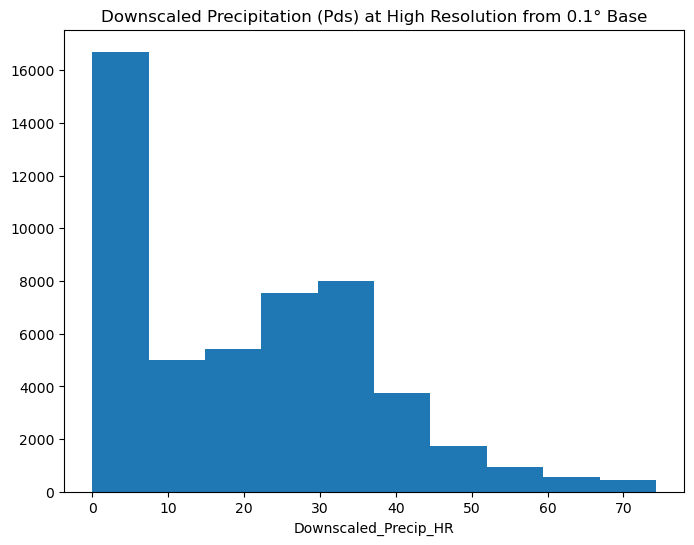

In [42]:
# NDVI-Based Precipitation Downscaling Pipeline (Python/xarray) - Annual Mean Version

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.interpolate import griddata

# --- 1. Define the exponential function used for regression ---
def exp_func(ndvi, a, b):
    return a * np.exp(b * ndvi)

# --- 2. Compute annual mean NDVI and total annual precipitation ---
def compute_annual_mean(ndvi_dict, precip_dict):
    ndvi_annual = {
        res: ndvi.groupby("time.year").mean("time")
        for res, ndvi in ndvi_dict.items()
    }
    precip_annual = {
        res: precip.groupby("time.year").sum("time")
        for res, precip in precip_dict.items()
    }
    ndvi_mean = {res: da.mean("year") for res, da in ndvi_annual.items()}
    precip_mean = {res: da.mean("year") for res, da in precip_annual.items()}
    return ndvi_mean, precip_mean

# --- 3. Fit exponential model and split/save data for plotting ---
def fit_exp_split_save(ndvi_da, precip_da, test_size=0.2, seed=42):
    ndvi = ndvi_da.values.flatten()
    precip = precip_da.values.flatten()
    mask = (~np.isnan(ndvi)) & (~np.isnan(precip)) & (precip >= 0)
    ndvi = ndvi[mask]
    precip = precip[mask]

    x_train, x_test, y_train, y_test = train_test_split(ndvi, precip, test_size=test_size, random_state=seed)
    popt, _ = curve_fit(exp_func, x_train, y_train, maxfev=10000)
    a, b = popt

    y_pred_test = exp_func(x_test, a, b)
    rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    r2 = r2_score(y_test, y_pred_test)

    return {
        "a": a, "b": b, "r2": r2, "rmse": rmse,
        "x_train": x_train, "y_train": y_train,
        "x_test": x_test, "y_test": y_test,
        "y_pred_test": y_pred_test
    }

# --- 4. Compute LR residuals ---
def compute_lr_residuals(ndvi_lr, precip_lr, a, b):
    pe_lr = exp_func(ndvi_lr, a, b)
    delta_lr = precip_lr - pe_lr
    return pe_lr, delta_lr

# --- 5. Interpolate residuals to high resolution ---
def interpolate_residuals(delta_lr, target_lat, target_lon):
    lon_lr, lat_lr = np.meshgrid(delta_lr.lon, delta_lr.lat)
    points_lr = np.column_stack((lat_lr.ravel(), lon_lr.ravel()))
    values_lr = delta_lr.values.ravel()
    mesh_lat, mesh_lon = np.meshgrid(target_lat, target_lon)
    points_hr = np.column_stack((mesh_lat.ravel(), mesh_lon.ravel()))
    delta_hr = griddata(points_lr, values_lr, points_hr, method='cubic')
    return xr.DataArray(delta_hr.reshape(len(target_lon), len(target_lat)).T, coords=[target_lat, target_lon], dims=['lat', 'lon'])

# --- 6. Compute high-resolution precipitation estimate ---
def compute_highres_precip(ndvi_hr, a, b, delta_hr):
    pe_hr = exp_func(ndvi_hr, a, b)
    return pe_hr + delta_hr

# --- 7. Evaluate results with ground-truth high-res precip ---
def evaluate(predict, truth):
    mask = (~np.isnan(predict)) & (~np.isnan(truth))
    rmse = mean_squared_error(truth[mask], predict[mask], squared=False)
    r2 = r2_score(truth[mask], predict[mask])
    return rmse, r2

# --- MAIN PIPELINE EXECUTION ---

# Step 1: Compute annual means from monthly data
ndvi_mean, precip_mean = compute_annual_mean(ndvi_resampled, precip_resampled)

# Step 2: Fit exponential functions and store fit details
fit_details = {}
for res in ndvi_mean:
    ndvi = ndvi_mean[res]
    precip = precip_mean[res].precipitation if hasattr(precip_mean[res], 'precipitation') else precip_mean[res]
    fit_details[res] = fit_exp_split_save(ndvi, precip)

# Step 3: Plot fits and find best resolution
fig, axes = plt.subplots(ncols=len(fit_details), figsize=(6 * len(fit_details), 5))
if len(fit_details) == 1:
    axes = [axes]

for ax, (res, result) in zip(axes, fit_details.items()):
    x_train, y_train = result["x_train"], result["y_train"]
    x_test, y_test, y_pred_test = result["x_test"], result["y_test"], result["y_pred_test"]
    a, b = result["a"], result["b"]
    x_line = np.linspace(min(x_train.min(), x_test.min()), max(x_train.max(), x_test.max()), 100)
    y_line = exp_func(x_line, a, b)
    ax.scatter(x_train, y_train, s=10, label="Train", alpha=0.5)
    ax.scatter(x_test, y_test, s=10, label="Test", alpha=0.5, color="red")
    ax.plot(x_line, y_line, label=f"Fit: a={a:.2f}, b={b:.2f}", color="black")
    ax.set_title(f"P_LR: Resolution {res}° - R²: {result['r2']:.3f}, RMSE: {result['rmse']:.2f}")
    ax.set_xlabel("NDVI")
    ax.set_ylabel("Precipitation")
    ax.legend()

plt.tight_layout()
plt.show()

# Step 4: Compute P_LR, residuals, interpolate to high resolution, and generate Pds
best_res = max(fit_details.items(), key=lambda x: x[1]['r2'])[0]
best_model = fit_details[best_res]
a_best, b_best = best_model['a'], best_model['b']
best_ndvi_lr = ndvi_mean[best_res]
best_precip_lr = precip_mean[best_res].precipitation if hasattr(precip_mean[best_res], 'precipitation') else precip_mean[best_res]

pe_lr, delta_lr = compute_lr_residuals(best_ndvi_lr, best_precip_lr, a_best, b_best)
# NEW: keep time dimension
ndvi_by_year = modis001.vegetation_index.groupby("time.year").mean("time")
pds_list = []

for year in ndvi_by_year.year.values:
    ndvi_hr = ndvi_by_year.sel(year=year)
    pe_hr = a_best * np.exp(b_best * ndvi_hr)
    delta_hr = delta_lr.interp_like(ndvi_hr, method="linear")
    pds_year = (pe_hr + delta_hr).where((pe_hr + delta_hr) >= 0, 0)
    pds_year = pds_year.expand_dims(time=[np.datetime64(f"{year}-01-01")])
    pds_list.append(pds_year)

# Concatenate along time
pds = xr.concat(pds_list, dim="time")
pds.name = "Downscaled_Precip_HR"

pds = pds.where(pds >= 0, 0)

# Step 5: Visualize final downscaled precipitation
plt.figure(figsize=(8, 6))
pds.plot()
plt.title(f"Downscaled Precipitation (Pds) at High Resolution from {best_res}° Base")
plt.show()

In [43]:
pds

<xarray.DataArray 'Downscaled_Precip_HR' (time: 10, lat: 50, lon: 100)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2016-01-01 ... 2024-01-01
  * lon      (lon) float32 -74.1 -74.09 -74.08 -74.07 ... -73.12 -73.11 -73.1
  * lat      (lat) float32 40.4 40.41 40.42 40.43 ... 40.87 40.88 40.89 40.9
    year     (time) int64 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024

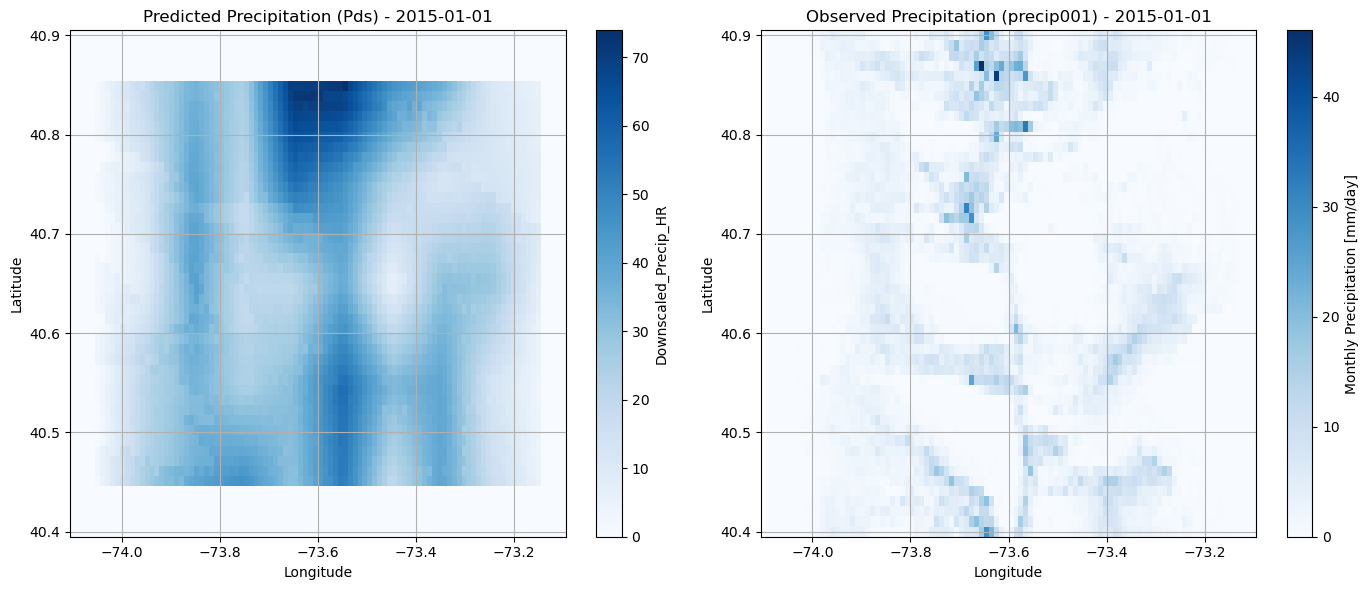

In [50]:
import numpy as np
import matplotlib.pyplot as plt

target_time = np.datetime64(pds.time.values[0])  # or randomly from intersection

# 在两个数据中用相同的时间选择
pds_single = pds.sel(time=target_time)
precip_single = precip001["precipitation"].sel(time=target_time)

# Step 3：创建并排图像
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pds_single.plot(ax=axes[0], cmap="Blues")

axes[0].set_title(f"Predicted Precipitation (Pds) - {str(target_time)[:10]}")


precip_single.plot(ax=axes[1], cmap="Blues")
axes[1].set_title(f"Observed Precipitation (precip001) - {str(target_time)[:10]}")

for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [56]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Step 1: 获取交集时间戳
common_times = np.intersect1d(pds.time.values, precip001.time.values)

# 初始化评估结果
all_rmse, all_r2, all_mae = [], [], []

for t in common_times:
    # Step 2: 按时间提取并对齐空间分辨率
    pds_single = pds.sel(time=t)
    precip_single = precip001["precipitation"].sel(time=t)
    precip_interp = precip_single.interp_like(pds_single)

    # Step 3: 去除 NaN 并展开成 1D
    y_true = precip_interp.values.flatten()
    y_pred = pds_single.values.flatten()
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        continue  # skip if no valid pixels

    # Step 4: 计算指标
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    print(f"Time: {str(t)[:10]} → RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    all_rmse.append(rmse)
    all_r2.append(r2)
    all_mae.append(mae)

# Optional: 计算总体平均
if all_rmse:
    print("\nAverage across all matched time points:")
    print(f"Avg RMSE: {np.mean(all_rmse):.2f}")
    print(f"Avg R²: {np.mean(all_r2):.3f}")
    print(f"Avg MAE: {np.mean(all_mae):.2f}")
else:
    print("No matching time points with valid data found.")


Time: 2015-01-01 → RMSE: 24.30, R²: -46.730, MAE: 19.08
Time: 2016-01-01 → RMSE: 24.34, R²: -45.522, MAE: 19.03
Time: 2017-01-01 → RMSE: 24.23, R²: -62.671, MAE: 19.06
Time: 2018-01-01 → RMSE: 24.13, R²: -55.591, MAE: 18.97
Time: 2019-01-01 → RMSE: 24.36, R²: -55.770, MAE: 19.14
Time: 2020-01-01 → RMSE: 24.40, R²: -54.637, MAE: 19.12
Time: 2021-01-01 → RMSE: 24.36, R²: -57.205, MAE: 19.17
Time: 2022-01-01 → RMSE: 24.44, R²: -61.486, MAE: 19.16
Time: 2023-01-01 → RMSE: 24.37, R²: -66.096, MAE: 19.15
Time: 2024-01-01 → RMSE: 24.42, R²: -49.621, MAE: 19.23

Average across all matched time points:
Avg RMSE: 24.33
Avg R²: -55.533
Avg MAE: 19.11


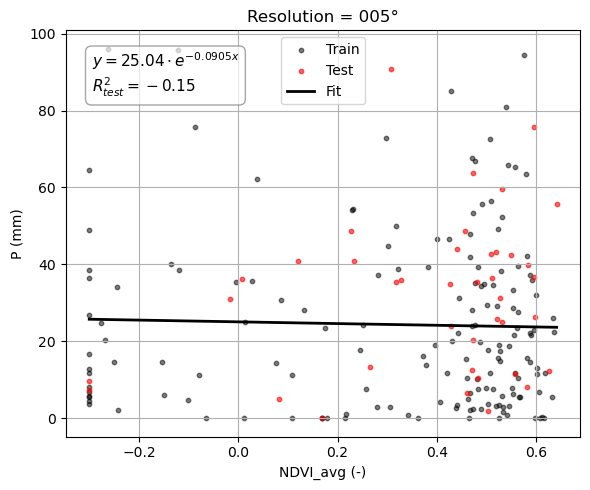

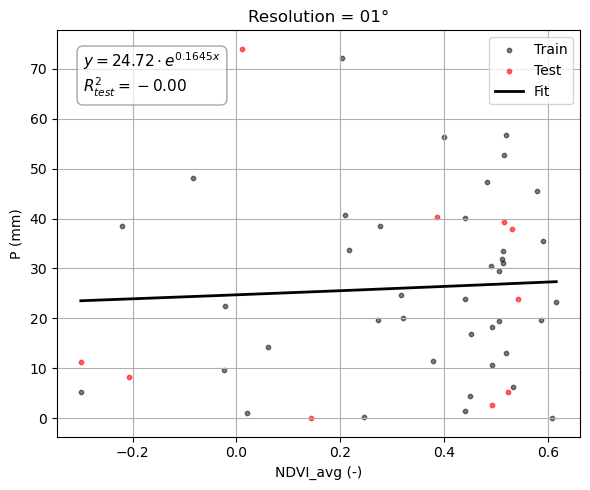

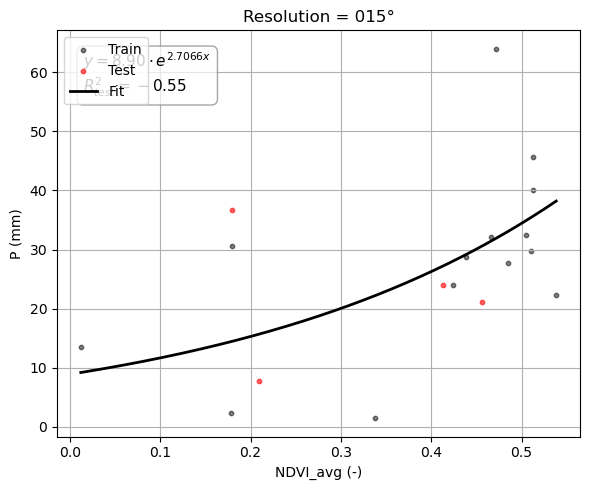

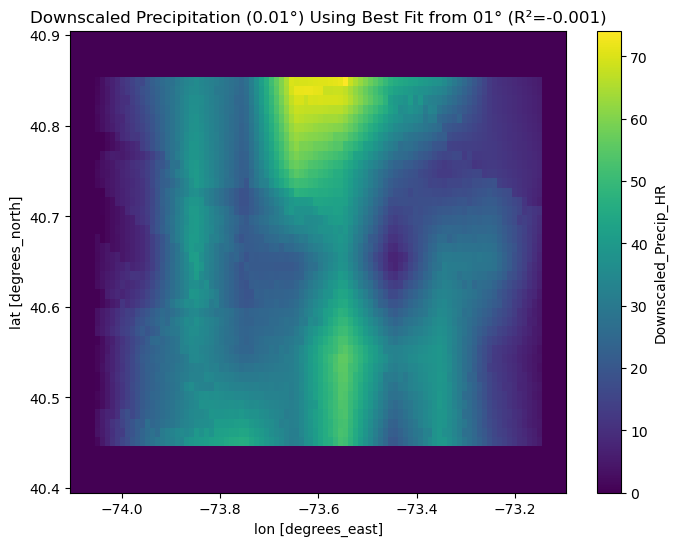

In [38]:
# NDVI-Based Precipitation Downscaling Pipeline (Python/xarray) - Multi-resolution Model Selection and High-res Estimation

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.interpolate import griddata

# --- 1. Define the exponential function ---
def exp_func(ndvi, a, b):
    return a * np.exp(b * ndvi)

# --- 2. Fit model and return metrics ---
def fit_exp_model(ndvi_da, precip_da, test_size=0.2, seed=42):
    ndvi = ndvi_da.values.flatten()
    precip = precip_da.values.flatten()
    mask = (~np.isnan(ndvi)) & (~np.isnan(precip)) & (precip >= 0)
    ndvi = ndvi[mask]
    precip = precip[mask]
    x_train, x_test, y_train, y_test = train_test_split(ndvi, precip, test_size=test_size, random_state=seed)
    popt, _ = curve_fit(exp_func, x_train, y_train, maxfev=10000)
    a, b = popt
    y_pred_test = exp_func(x_test, a, b)
    r2 = r2_score(y_test, y_pred_test)
    rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    return a, b, r2, rmse, x_train, y_train, x_test, y_test


# --- 3. Compute residuals ---
def compute_residuals(ndvi, precip, a, b):
    pe = exp_func(ndvi, a, b)
    delta = precip - pe
    return pe, delta

# --- 4. Interpolate residuals ---
def interpolate_residuals(delta_lr, target_lat, target_lon):
    lon_lr, lat_lr = np.meshgrid(delta_lr.lon, delta_lr.lat)
    points_lr = np.column_stack((lat_lr.ravel(), lon_lr.ravel()))
    values_lr = delta_lr.values.ravel()
    mesh_lat, mesh_lon = np.meshgrid(target_lat, target_lon)
    points_hr = np.column_stack((mesh_lat.ravel(), mesh_lon.ravel()))
    delta_hr = griddata(points_lr, values_lr, points_hr, method='cubic')
    return xr.DataArray(delta_hr.reshape(len(target_lon), len(target_lat)).T, coords=[target_lat, target_lon], dims=['lat', 'lon'])

# --- 5. Evaluate ---
def evaluate(predict, truth):
    mask = (~np.isnan(predict)) & (~np.isnan(truth))
    rmse = mean_squared_error(truth[mask], predict[mask], squared=False)
    r2 = r2_score(truth[mask], predict[mask])
    return rmse, r2
def plot_fit_scatter_with_train_test(x_train, y_train, x_test, y_test, a, b, r2, res_label):
    """
    绘制带拟合曲线的训练/测试集散点图（黑：训练，红：测试）
    """
    # 拟合线范围
    x_line = np.linspace(min(x_train.min(), x_test.min()), max(x_train.max(), x_test.max()), 200)
    y_line = exp_func(x_line, a, b)

    plt.figure(figsize=(6, 5))
    plt.scatter(x_train, y_train, s=10, color='black', alpha=0.5, label='Train')
    plt.scatter(x_test, y_test, s=10, color='red', alpha=0.6, label='Test')
    plt.plot(x_line, y_line, color='black', linewidth=2, label='Fit')

    plt.xlabel("NDVI_avg (-)")
    plt.ylabel("P (mm)")
    plt.title(f"Resolution = {res_label}°")

    # 显示指数公式和 R²
    plt.text(0.05, 0.95,
             f"$y = {a:.2f} \cdot e^{{{b:.4f}x}}$\n$R^2_{{test}} = {r2:.2f}$",
             transform=plt.gca().transAxes,
             verticalalignment='top',
             fontsize=11,
             bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.7))

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- MAIN EXECUTION ---

# Input datasets: modis005, modis01, modis015 (NDVI); precip005, precip01, precip015 (Precip)
# Each is an xarray DataArray with dimensions (time, lat, lon)

res_levels = ["005", "01", "015"]
ndvi_dict = {"005": ndvi_resampled['0.05'], "01": ndvi_resampled['0.1'], "015": ndvi_resampled['0.15']}
precip_dict = {"005": precip_resampled['0.05'], "01": precip_resampled['0.1'], "015": precip_resampled['0.15']}


fit_results = {}

# Step 1: Fit models for each resolution and record R²
for res in res_levels:
    ndvi_avg = ndvi_dict[res].groupby("time.year").mean("time").mean("year")
    precip_avg = precip_dict[res]['precipitation'].groupby("time.year").sum("time").mean("year")

    a, b, r2, rmse, x_tr, y_tr, x_te, y_te = fit_exp_model(ndvi_avg, precip_avg)
    fit_results[res] = {
        "a": a, "b": b, "r2": r2, "rmse": rmse,
        "ndvi": ndvi_avg, "precip": precip_avg
    }
    plot_fit_scatter_with_train_test(x_tr, y_tr, x_te, y_te, a, b, r2, res_label=res)


# Step 2: Select best model (highest R²)
best_res = max(fit_results, key=lambda r: fit_results[r]["r2"])
best_model = fit_results[best_res]
a_opt, b_opt = best_model['a'], best_model['b']

# Step 3: Apply best model to 0.01° NDVI
ndvi_hr = modis001.vegetation_index.groupby("time.year").mean("time").mean("year")
pe_hr = exp_func(ndvi_hr, a_opt, b_opt)

# Step 4: Compute residuals at low resolution, then interpolate to high resolution
_, delta_lr = compute_residuals(best_model['ndvi'], best_model['precip'], a_opt, b_opt)
delta_hr = delta_lr.interp_like(ndvi_hr, method="linear")

# Step 5: Final Pds = Pe_HR + Delta_HR
pds = pe_hr + delta_hr
pds.name = "Downscaled_Precip_HR"
pds = pds.where(pds >= 0, 0)

# Step 6: Visualize
plt.figure(figsize=(8, 6))
pds.plot()
plt.title(f"Downscaled Precipitation (0.01°) Using Best Fit from {best_res}° (R²={best_model['r2']:.3f})")
plt.show()


# 2 MLR

In [61]:
precip01

<xarray.Dataset>
Dimensions:        (time: 119, lat: 5, lon: 10)
Coordinates:
  * time           (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2024-11-01
  * lon            (lon) float32 -74.05 -73.95 -73.85 ... -73.35 -73.25 -73.15
  * lat            (lat) float32 40.45 40.55 40.65 40.75 40.85
Data variables:
    precipitation  (time, lat, lon) float32 -348.3 1.699 ... 0.3174 0.05378
Attributes:
    title:                NASA IMERG Precipitation Data for New York City (20...
    description:          Monthly precipitation data from IMERG
    history:              Created on 2025-04-15
    source:               NASA IMERG
    spatial_resolution:   1000m
    temporal_resolution:  Monthly average
    west_lon:             -74.1
    east_lon:             -73.1
    south_lat:            40.4
    north_lat:            40.9

数据准备

modis001: 高分辨率回归因子（月度）；

precip001: 高分辨率真实降水数据（月度）；

接下来的分析都是在年度数据上进行的，对以上月度数据进行平均。

网格重采样至 0.05°、0.1°、0.15°

对 modis001 和 precip001 分别进行 grid averaging（均值汇聚）；

构建 ndvi_resampled 和 precip_resampled 字典；

按分辨率在每个分辨率下分别训练一个 MLR 模型（Multivariate Linear Regression）

自变量为 surface_temperature,vegetation_index,evapotranspiration,burned_area，因变量为 大于等于0的precipitation；

拟合并记录每个分辨率下的残差 delta = precip - predicted；

残差上采样到高分辨率（和0.01degree的对齐）

插值 delta_lr → delta_hr（e.g. linear/cubic）；

高分分辨率预测图生成

p_hr = predicted_hr + delta_hr；

将 p_hr 与 precip001 对比验证 RMSE, MAE, R²；

注意划分训练集和测试集

原始输入数据 (modis001, precip001)
         │
         ▼
  多尺度重采样 (0.05°, 0.1°, 0.15°)
         │
         ▼
   年度平均 (NDVI, Temp, ET & Precip)
         │
         ▼
  拟合 MLR 模型 (每个尺度一个)
         │
         ▼
  选出最佳分辨率模型 (R²最大)
         │
         ├────────────┐
         ▼            ▼
  残差计算 Δ_LR      多年预测 Pe_HR (每年输入)
         │            │
         └─────┬──────┘
               ▼
      残差 Δ_LR → Δ_HR 插值
               ▼
      每年：Pds = Pe_HR + Δ_HR
               ▼
      输出逐年高分辨率降水 pds(time, lat, lon)


In [79]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# --- MLR fitting ---
def fit_mlr_model(X_ds, y_da, test_size=0.2, seed=42):
    X = np.column_stack([X_ds[var].values for var in X_ds.data_vars])
    y = y_da.values
    # mask = (~np.isnan(X).any(axis=1)) & (~np.isnan(y)) & (y >= 0)
    # X = X[mask]
    # y = y[mask]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    model = LinearRegression().fit(x_train, y_train)
    y_pred_test = model.predict(x_test)
    r2 = r2_score(y_test, y_pred_test)
    rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    return model, r2, rmse

# --- Predict high-resolution PDS by year ---
def predict_pds_by_year(model, modis001, delta_hr, predictor_vars):
    years = np.unique(modis001.time.dt.year.values)
    pds_list = []
    for year in years:
        X_hr_year = xr.Dataset({
            var: modis001[var].sel(time=str(year)).mean('time') for var in predictor_vars
        })
        X_matrix = np.column_stack([X_hr_year[var].values.flatten() for var in X_hr_year.data_vars])
        pred_vals = model.predict(X_matrix).reshape(X_hr_year[list(X_hr_year.data_vars)[0]].shape)
        pe_hr = xr.DataArray(pred_vals, coords=X_hr_year[list(X_hr_year.data_vars)[0]].coords, dims=['lat', 'lon'])
        delta_hr_aligned = delta_hr.interp_like(pe_hr)
        pds_year = (pe_hr + delta_hr_aligned).where((pe_hr + delta_hr_aligned) >= 0, 0)
        pds_year = pds_year.expand_dims(time=[np.datetime64(f"{year}-01-01")])
        pds_list.append(pds_year)
    return xr.concat(pds_list, dim="time")

# --- Grid averaging helper ---
def grid_avg_resample(da, res_deg):
    step = int(np.round(res_deg / 0.01))  # Assuming native resolution is 0.01°
    return da.coarsen(lat=step, lon=step, boundary="trim").mean()

# --- Main Pipeline ---
def run_downscaling(modis001, precip01, precip001):
    predictor_vars = ["vegetation_index", "surface_temperature", "evapotranspiration"]
    res_map = {"0.05": 0.05, "0.1": 0.1, "0.15": 0.15}

    # Step 1: Grid averaging
    predictor_resampled = {
        var: {res: grid_avg_resample(modis001[var], deg) for res, deg in res_map.items()}
        for var in predictor_vars
    }
    precip_resampled = {res: grid_avg_resample(precip01.precipitation.where(precip01.precipitation > 0), deg)
                        for res, deg in res_map.items()}

    fit_results = {}

    # Step 2: Train models for each resolution
    for res in res_map:
        X_ds = xr.Dataset({var: predictor_resampled[var][res].groupby("time.year").mean("time")
                           for var in predictor_vars})
        y = precip_resampled[res].groupby("time.year").mean("time")

        # Stack predictor variables and response
        X_stack = X_ds.to_array().stack(samples=("year", "lat", "lon")).transpose("samples", "variable")
        y_stack = y.stack(samples=("year", "lat", "lon"))

        # Build final X_ds and y_da with matching 'samples' dimension
        X_ds_final = xr.Dataset({
            var: (["samples"], X_stack.sel(variable=var).values) for var in X_ds.data_vars
        })
        y_da_final = xr.DataArray(y_stack.values, dims=["samples"])

        model, r2, rmse = fit_mlr_model(X_ds_final, y_da_final)
        fit_results[res] = {
            "model": model,
            "r2": r2,
            "rmse": rmse,
            "X_ds": X_ds_final,
            "y_da": y_da_final
        }

    # Step 3: Choose best model
    best_res = max(fit_results, key=lambda r: fit_results[r]["r2"])
    print(f"Best model: {best_res}° (R²={fit_results[best_res]['r2']:.3f}, RMSE={fit_results[best_res]['rmse']:.3f})")
    best_model = fit_results[best_res]["model"]
    X_lr = fit_results[best_res]["X_ds"]
    y_lr = fit_results[best_res]["y_da"]

    # Step 4: Interpolate residuals to HR
    X_matrix = np.column_stack([X_lr[var].values for var in X_lr.data_vars])
    y_array = y_lr.values
    # mask = (~np.isnan(X_matrix).any(axis=1)) & (~np.isnan(y_array))
    y_pred = best_model.predict(X_matrix)
    delta_vals = y_array - y_pred

    # Construct delta_lr DataArray
    n = int(np.sqrt(len(delta_vals)))  # Assumes near-square grid — adjust if needed
    delta_lr = xr.DataArray(np.full((n, n), np.nan), dims=["lat", "lon"])
    delta_lr.values.flat[:len(delta_vals)] = delta_vals

    # Interpolate to high-res grid
    delta_hr = delta_lr.interp_like(modis001["vegetation_index"].isel(time=0), method="linear")

    # Step 5: Predict high-res Pds
    pds = predict_pds_by_year(best_model, modis001, delta_hr, predictor_vars)

    # Step 6: Visualize
    plt.figure(figsize=(8, 6))
    pds.mean("time").plot(cmap="Blues")
    plt.title(f"Mean Predicted Precipitation (Pds) using {best_res}° model")
    plt.tight_layout()
    plt.show()

    return pds

result_pds = run_downscaling(modis001, precip01, precip001)



ValueError: Found input variables with inconsistent numbers of samples: [2000, 20]

In [70]:
# Step 1: 生成逐年降水真实值，并统一 time 维度
precip_yearly = precip001.precipitation.groupby("time.year").sum("time")
precip_yearly = precip_yearly.rename({'year': 'time'})
precip_yearly = precip_yearly.assign_coords(time=pds.time)

# Step 2: 评估函数不变
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_by_year(pds, truth):
    r2_list = []
    rmse_list = []
    years = pds.time.dt.year.values

    for i, year in enumerate(years):
        pred = pds.isel(time=i).values.flatten()
        real = truth.isel(time=i).values.flatten()
        mask = (~np.isnan(pred)) & (~np.isnan(real))
        r2 = r2_score(real[mask], pred[mask])
        rmse = mean_squared_error(real[mask], pred[mask], squared=False)
        r2_list.append(r2)
        rmse_list.append(rmse)

    return years, r2_list, rmse_list

# Step 3: 调用
years, r2s, rmses = evaluate_by_year(pds, precip_yearly)


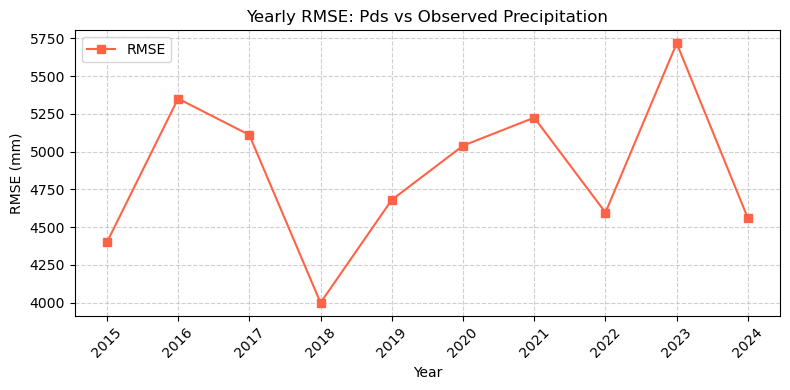

In [68]:
plt.figure(figsize=(8, 4))
plt.plot(years, rmses, marker='s', color='tomato', label='RMSE')
plt.title("Yearly RMSE: Pds vs Observed Precipitation")
plt.xlabel("Year")
plt.ylabel("RMSE (mm)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(years, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


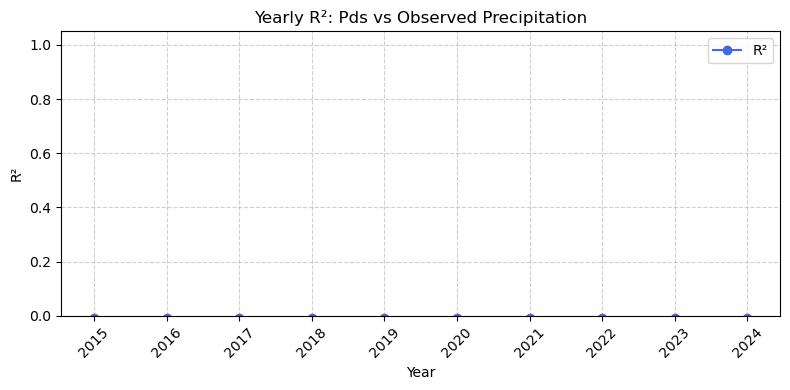

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(years, r2s, marker='o', color='royalblue', label='R²')
plt.ylim(0, 1.05)
plt.title("Yearly R²: Pds vs Observed Precipitation")
plt.xlabel("Year")
plt.ylabel("R²")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(years, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


你这段分析流程是一个**经典的统计降尺度建模框架**，下面我对每个步骤进行**详细解释**，并给出背后的数学逻辑和可视化建议，帮助你更系统地理解这套方法：

---

### 🧾 原始数据说明：
- `modis001`: MODIS 遥感数据，高分辨率（如 0.01°），包含多个回归因子，**按月度记录**。
- `precip001`: 高分辨率的实测或再分析降水数据（月度），同样为 **0.01° 分辨率**。

---

### ✅ 分析流程详解：

#### 1️⃣ **时间聚合：月→年**

对所有因子进行**年度平均**：
```python
def annual_mean(ds):
    return ds.groupby("time.year").mean("time")
```
解释：这是为了减少月度噪声，更稳定地拟合年降水变化趋势。

---

#### 2️⃣ **空间下采样：高分分辨率 → 多种低分辨率**

将高分辨率的因子和降水数据分别下采样至：
- 0.05°
- 0.1°
- 0.15°

使用 `xarray.coarsen()`，例如：
```python
da.coarsen(lat=int(step / 0.01), lon=int(step / 0.01), boundary="trim").mean()
```
含义：对 `0.01°` 的网格，按 `step/0.01` 的窗口进行平均，得到较粗的栅格。

---

#### 3️⃣ **训练多个 MLR 模型**

对每个分辨率的数据构建多元线性回归模型（MLR）：
- 自变量：多个 MODIS 因子
- 因变量：降水（年均）
- 所有年份共同参与训练

```python
reg = LinearRegression().fit(X, y)
```

---

#### 4️⃣ **选择最佳模型（按 R²）**

比较不同分辨率下的回归结果，选择 **R² 最高的模型**，表示解释能力最强：
```python
r2 = r2_score(y_true, y_pred)
```

---

#### 5️⃣ **残差插值 Δ_LR → Δ_HR**

对该最佳模型在低分辨率下的预测残差（Δ = true - predicted）：
- 插值回高分辨率栅格上（Δ_HR）
- 方法可以选 `linear`, `cubic`, `nearest` 等

```python
delta_hr = delta_lr.interp_like(modis001, method="linear")
```

---

#### 6️⃣ **逐年生成高分辨率降水预测图 Pds**

每年分别进行高分辨率预测：
- Pe_HR = 高分辨率输入数据（回归因子）输入低分模型得到的预测
- Δ_HR 是残差插值结果
- 最终预测：  
  \[
  P_{ds}(t, i, j) = P_e^{HR}(t, i, j) + \Delta^{HR}(t, i, j)
  \]

---

#### 7️⃣ **可视化**

绘制最终预测的时间平均图：
```python
pds_mean = pds.mean("time")
pds_mean.plot()
```
这样你就能看到**空间分布的年均降水图**（预测值），可用于与实测值对比。

---

### 📌 小结：整个流程是一种“两步降尺度”方法
- **第一步**：在低分辨率上用 MLR 拟合因果关系。
- **第二步**：将误差信息精细插值，提升空间分辨率，保留 MODIS 的细节。

如果你还想加入 **不确定性分析（如置信区间）** 或 **对比实际降水精度指标（RMSE, MAE）**，也可以在这个框架上拓展。


In [ ]:
将高分辨率数据下采样到 3 个分辨率（0.05°、0.1°、0.15°）；

训练多个 MLR 模型（每个分辨率一个），但都是基于所有年份的数据；

选择性能最优模型（最高 R²）；

残差插值：将低分辨率的残差场 Δ_LR 插值到高分辨率 Δ_HR；

生成逐年高分辨率降水预测 Pds(time, lat, lon)，Pe_HR + Δ_HR；

可视化：绘制 Pds 的时间平均图。